In [21]:
import numpy as np
import polars as pl
import os
from pathlib import Path
from typing import List, Tuple, Union
from datetime import datetime, timedelta
from pydantic import BaseModel
from loguru import logger
from enum import Enum
import random


class EndStatus(Enum):
    DISSIPATED = 0
    MOVE_OUT_OF_RESPONSIBILITY = 1
    MERGED = 2
    NEARLY_STATIONARY = 3


class CycloneCategory(Enum):
    BELOW_TD_OR_UNKNOWN = 0
    TROPICAL_DEPRESSION = 1  # 热带低压 (TD, 10.8-17.1m/s)
    TROPICAL_STORM = 2  # 热带风暴 (TS, 17.2-24.4 m/s)
    SEVERE_TROPICAL_STORM = 3  # 强热带风暴 (STS, 24.5-32.6 m/s)
    TYPHOON = 4  # 台风 (TY, 32.7-41.4 m/s)
    SEVERE_TYPHOON = 5  # 强台风 (STY, 41.5-50.9 m/s)
    SUPER_TYPHOON = 6  # 超强台风 (SuperTY, ≥51.0 m/s)
    EXTRATROPICAL = 9  # 变性 (The change is complete)


class HurricaneHeader(BaseModel):
    data_type: int
    country_code: int
    data_count: int
    hurricane_code: int
    china_hurricane_code: int
    end_status: EndStatus
    time_interval_hr: int
    hurricane_name: str
    dataset_record_time: datetime


class HurricaneEntry(BaseModel):
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


class Hurricane(BaseModel):
    header: HurricaneHeader
    entries: List[HurricaneEntry]


script_folder = Path(os.getcwd())
dataset_folder = script_folder / "CMABSTdata"

# https://tcdata.typhoon.org.cn/zjljsjj.html
# example_file = dataset_folder / "CH2022BST.txt"
example_file = dataset_folder / "CH1950BST.txt"
logger.info(f"example_file: {example_file}")


def parse_header(line: str) -> HurricaneHeader:
    entry = line.split()
    data_type = int(entry[0])
    country_code = int(entry[1])
    data_count = int(entry[2])
    hurricane_code = int(entry[3])
    try:
        china_hurricane_code = int(entry[4])
    except ValueError:
        # might be a tuple (a,b)
        codes = entry[4].split(",")
        china_hurricane_code = int(codes[0])
    hurricane_end_enum = int(entry[5])
    end_status = EndStatus(hurricane_end_enum)
    time_interval_hr = int(entry[6])
    hurricane_name = entry[7]
    dataset_record_time = entry[8]
    time_format = "%Y%m%d"
    dataset_record_time = datetime.strptime(dataset_record_time, time_format)
    return HurricaneHeader(data_type=data_type,
                           country_code=country_code,
                           data_count=data_count,
                           hurricane_code=hurricane_code,
                           china_hurricane_code=china_hurricane_code,
                           end_status=end_status,
                           time_interval_hr=time_interval_hr,
                           hurricane_name=hurricane_name,
                           dataset_record_time=dataset_record_time)


def parse_entry(line: str) -> HurricaneEntry:
    entry = line.split()
    date_str = entry[0]
    time_format = "%Y%m%d%H"
    date = datetime.strptime(date_str, time_format)
    category = int(entry[1])
    hurricane_category = CycloneCategory(category)
    latitude = float(int(entry[2])) / 10.0
    longitude = float(int(entry[3])) / 10.0
    # in hPa
    lowest_pressure = int(entry[4])
    # 2分钟平均近中心最大风速(MSW, m/s)
    # WND=9 表示 MSW < 10m/s,
    # WND=0 为缺测
    wind_speed = int(entry[5])
    # not sure about OWD
    return HurricaneEntry(date=date,
                          category=hurricane_category,
                          latitude=latitude,
                          longitude=longitude,
                          lowest_pressure=lowest_pressure,
                          wind_speed=wind_speed)


def parse_dataset(filename):
    hurricanes: list[Hurricane] = []
    with open(filename, "r") as f:
        try:
            while True:
                # check if the line is empty
                l = f.readline()
                if not l:
                    break
                header = parse_header(l)
                count = header.data_count
                hurricane_entries = []
                for i in range(count):
                    entry = parse_entry(f.readline())
                    hurricane_entries.append(entry)
                hurricane = Hurricane(header=header, entries=hurricane_entries)
                hurricanes.append(hurricane)
        except ValueError as e:
            logger.error(f"ValueError: {e} for {filename}")
        except IndexError as e:
            logger.warning(f"IndexError: {e} for {filename}")
        except EOFError:
            logger.info(f"EOFError for {filename}")
    return hurricanes



2024-04-22 16:34:25.994 | INFO     | __main__:<module>:63 - example_file: d:\毕业论文\数据集\hurricane_stuff-1\CMABSTdata\CH1950BST.txt


In [22]:
total_dataset: list[Hurricane] = []

for file in dataset_folder.glob("*.txt"):
    hurricanes = parse_dataset(file)
    total_dataset.extend(hurricanes)

logger.info(f"total_dataset: {len(total_dataset)}")

2024-04-22 16:34:28.270 | INFO     | __main__:<module>:7 - total_dataset: 2469


In [23]:
class FlatHurricaneEntry(BaseModel):
    sample_id: int
    name: str
    china_hurricane_code: int
    date: datetime
    category: CycloneCategory
    latitude: float
    longitude: float
    lowest_pressure: int
    wind_speed: int


def flat_hurricane_entries(
        hurricanes: list[Hurricane]) -> List[FlatHurricaneEntry]:
    counter = 0
    def flat_one(h: Hurricane, counter: int = counter):
        name = h.header.hurricane_name
        hurricane_code = h.header.hurricane_code
        entries = h.entries
        return [
            FlatHurricaneEntry(sample_id=counter,
                               name=name,
                               china_hurricane_code=hurricane_code,
                               date=e.date,
                               category=e.category,
                               latitude=e.latitude,
                               longitude=e.longitude,
                               lowest_pressure=e.lowest_pressure,
                               wind_speed=e.wind_speed) for e in entries
        ]

    entries = []
    for h in hurricanes:
        entries.extend(flat_one(h, counter))
        counter += 1
    return entries


flatten_entries = [
    e.model_dump() for e in flat_hurricane_entries(total_dataset)
]


def entry_enum_to_number(entry: dict[str, any]) -> dict[str, any]:
    entry['category'] = entry['category'].value
    return entry


flatten_entries_without_enum = [
    entry_enum_to_number(e) for e in flatten_entries
]

In [24]:
df = pl.DataFrame(flatten_entries_without_enum)
df_filtered = df.filter(df["wind_speed"] != 0)
df_filtered.describe()

statistic,sample_id,name,china_hurricane_code,date,category,latitude,longitude,lowest_pressure,wind_speed
str,f64,str,f64,str,f64,f64,f64,f64,f64
"""count""",65796.0,"""65796""",65796.0,"""65796""",65796.0,65796.0,65796.0,65796.0,65796.0
"""null_count""",0.0,"""0""",0.0,"""0""",0.0,0.0,0.0,0.0,0.0
"""mean""",1307.737796,null,17.502265,"""1985-09-05 05:…",2.866664,20.73495,133.459558,984.894963,25.891893
"""std""",699.270657,null,10.381192,null,2.121499,8.752285,16.292624,21.13435,14.21218
"""min""",0.0,"""(nameless)""",1.0,"""1949-01-15 00:…",0.0,0.5,95.0,870.0,8.0
"""25%""",731.0,null,9.0,"""1968-06-01 00:…",1.0,14.5,121.2,975.0,15.0
"""50%""",1337.0,null,17.0,"""1984-10-31 00:…",2.0,19.4,131.7,992.0,20.0
"""75%""",1918.0,null,25.0,"""2003-06-17 18:…",4.0,25.5,143.9,1000.0,35.0
"""max""",2468.0,"""Zola""",53.0,"""2022-12-13 06:…",9.0,70.1,243.9,1016.0,110.0


In [25]:
from numpy.typing import NDArray
from functools import reduce
# group by sample_id and iterate over the groups
grouped = df_filtered.group_by("sample_id")
from typing import Iterable, Iterator, Tuple, Union

EXPECTED_TIMESTAMP_COUNT = 20


def filter_out_short_sequence(id_and_df: tuple[int, pl.DataFrame]) -> bool:
    return id_and_df[1].height >= EXPECTED_TIMESTAMP_COUNT


def pad_or_truncate(
        id_and_df: tuple[int, pl.DataFrame]) -> tuple[pl.Series, pl.DataFrame]:
    group_id, df = id_and_df
    if df.height < EXPECTED_TIMESTAMP_COUNT:
        # pad with zeros
        diff = EXPECTED_TIMESTAMP_COUNT - df.height
        mask = pl.Series("mask", [True] * df.height + [False] * diff)
        zeros = pl.DataFrame({
            "sample_id": [group_id] * diff,
            "latitude": [0.0] * diff,
            "longitude": [0.0] * diff,
            "wind_speed": [0.0] * diff,
            "lowest_pressure": [0.0] * diff,
        })
        stacked = df.vstack(zeros)
        # sort by date
        return mask, stacked.sort("date")
    elif df.height >= EXPECTED_TIMESTAMP_COUNT:
        # truncate
        mask = pl.Series("mask", [True] * EXPECTED_TIMESTAMP_COUNT)
        return mask, df.head(EXPECTED_TIMESTAMP_COUNT)
    else:
        mask = pl.Series("mask", [True] * df.height)
        return mask, df


filtered = filter(filter_out_short_sequence, grouped)
padded = map(pad_or_truncate, filtered)


# for some reason, the reduce function is not working
def to_tensor(
        id_and_df: Iterable[tuple[int,
                                  pl.DataFrame]]) -> tuple[NDArray, NDArray]:
    init_mask, init_data = np.empty(
        (0, EXPECTED_TIMESTAMP_COUNT, 1)), np.empty(
            (0, EXPECTED_TIMESTAMP_COUNT, df_filtered.width))
    for mask, df in id_and_df:
        current_data = df.to_numpy()
        current_mask = np.expand_dims(mask.to_numpy(), axis=-1)
        try:
            new_data = np.vstack(
                (init_data, np.expand_dims(current_data, axis=0)))
            new_mask = np.vstack(
                (init_mask, np.expand_dims(current_mask, axis=0)))
        except ValueError as e:
            logger.error(f"ValueError: {e}")
            logger.info(
                f"init_data: {init_data.shape}, current_data: {current_data.shape}"
            )
            logger.info(
                f"init_mask: {init_mask.shape}, current_mask: {current_mask.shape}"
            )
            logger.info(
                f"init_data: {init_data}, current_data: {current_data}")
            logger.info(
                f"init_mask: {init_mask}, current_mask: {current_mask}")

        init_data, init_mask = new_data, new_mask
    return init_data, init_mask


data_with_id, mask = to_tensor(padded)
# remove the sample_id column
features = data_with_id[:, :, 1:]
display((features.shape, mask.shape))
#display(data_with_id)

C:\Users\Lenovo\AppData\Local\Temp\ipykernel_23192\3206117314.py:40: DeprecationWarning: `group_by` iteration will change to always return group identifiers as tuples. Pass `by` as a list to silence this warning, e.g. `group_by(['sample_id'])`.
  filtered = filter(filter_out_short_sequence, grouped)


((1599, 20, 8), (1599, 20, 1))

In [26]:
df_padded=features
display(df_padded)

array([[['(nameless)', 23, datetime.datetime(1995, 12, 7, 0, 0), ...,
         115.0, 1004, 12],
        ['(nameless)', 23, datetime.datetime(1995, 12, 7, 6, 0), ...,
         114.5, 1002, 15],
        ['(nameless)', 23, datetime.datetime(1995, 12, 7, 12, 0), ...,
         114.0, 1000, 15],
        ...,
        ['(nameless)', 23, datetime.datetime(1995, 12, 11, 6, 0), ...,
         113.8, 1004, 15],
        ['(nameless)', 23, datetime.datetime(1995, 12, 11, 12, 0), ...,
         113.5, 1004, 15],
        ['(nameless)', 23, datetime.datetime(1995, 12, 11, 18, 0), ...,
         113.0, 1004, 12]],

       [['Ruth', 22, datetime.datetime(1973, 10, 10, 18, 0), ..., 144.1,
         1005, 10],
        ['Ruth', 22, datetime.datetime(1973, 10, 11, 0, 0), ..., 143.1,
         1003, 15],
        ['Ruth', 22, datetime.datetime(1973, 10, 11, 6, 0), ..., 141.9,
         1003, 15],
        ...,
        ['Ruth', 22, datetime.datetime(1973, 10, 15, 0, 0), ..., 124.5,
         975, 40],
        ['Ruth',

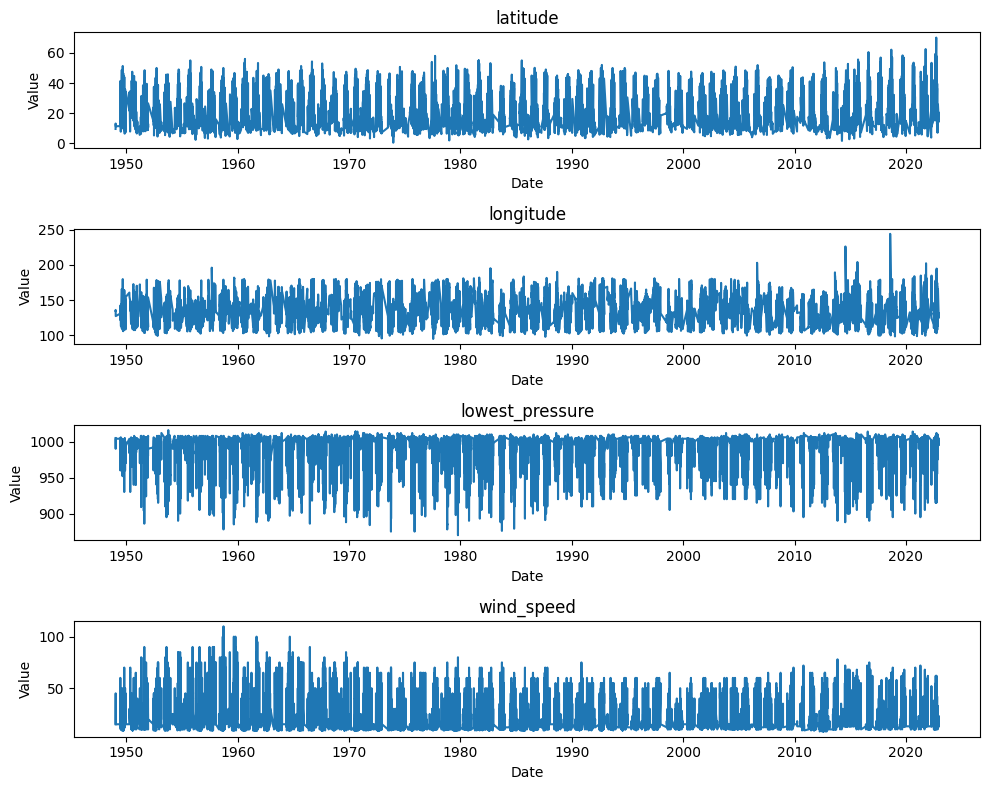

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取CSV文件，假设特征列分别为'date'、'latitude'、'longitude'、'lowest_pressure'、'wind_speed'
df = pd.read_csv('D:\毕业论文\数据集\hurricane_stuff-1\hurricane.csv', usecols=['date', 'latitude', 'longitude', 'lowest_pressure', 'wind_speed'], parse_dates=['date'])

# 设置'date'列为索引
df.set_index('date', inplace=True)

# 创建一个4x1的子图
fig, axes = plt.subplots(4, 1, figsize=(10, 8))

# 遍历每个特征，并在相应的子图中绘制时序图
for i, col in enumerate(df.columns):
    ax = axes[i]
    ax.plot(df.index, df[col])
    ax.set_title(col)
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


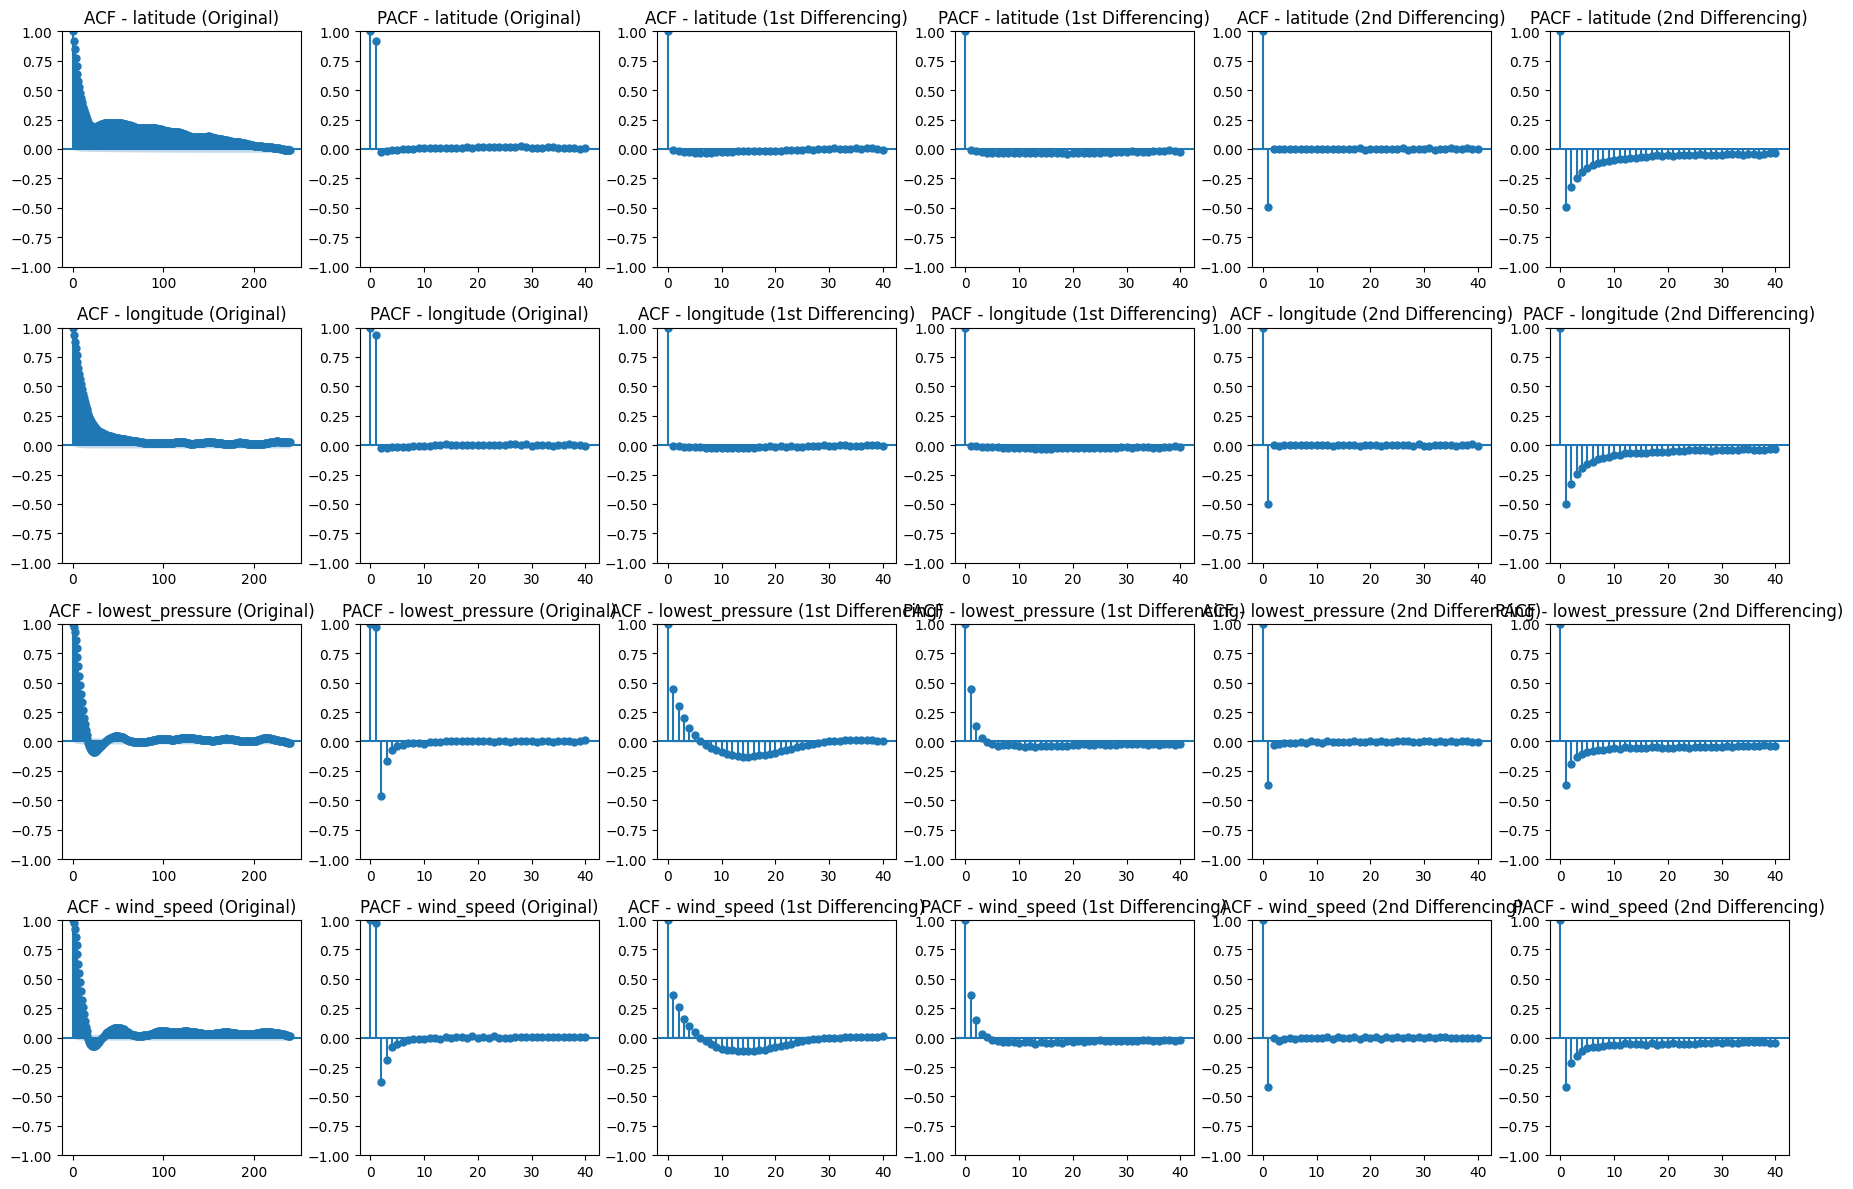

In [49]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# 创建一个4x6的子图，每个特征对应一列，每行对应原始序列、一阶差分、二阶差分
fig, axes = plt.subplots(4, 6, figsize=(18, 12))

# 遍历每个特征，并在相应的子图中绘制ACF和PACF图
for i, col in enumerate(df.columns):
    # 绘制原始序列的ACF和PACF图
    plot_acf(df[col], ax=axes[i, 0], lags=240)
    axes[i, 0].set_title(f'ACF - {col} (Original)')
    plot_pacf(df[col], ax=axes[i, 1], lags=40)
    axes[i, 1].set_title(f'PACF - {col} (Original)')
    
    # 计算一阶差分和二阶差分
    diff1 = df[col].diff().dropna()
    diff2 = diff1.diff().dropna()
    
    # 绘制一阶差分的ACF和PACF图
    plot_acf(diff1, ax=axes[i, 2], lags=40)
    axes[i, 2].set_title(f'ACF - {col} (1st Differencing)')
    plot_pacf(diff1, ax=axes[i, 3], lags=40)
    axes[i, 3].set_title(f'PACF - {col} (1st Differencing)')
    
    # 绘制二阶差分的ACF和PACF图
    plot_acf(diff2, ax=axes[i, 4], lags=40)
    axes[i, 4].set_title(f'ACF - {col} (2nd Differencing)')
    plot_pacf(diff2, ax=axes[i, 5], lags=40)
    axes[i, 5].set_title(f'PACF - {col} (2nd Differencing)')

# 调整子图之间的间距
plt.tight_layout()
plt.show()


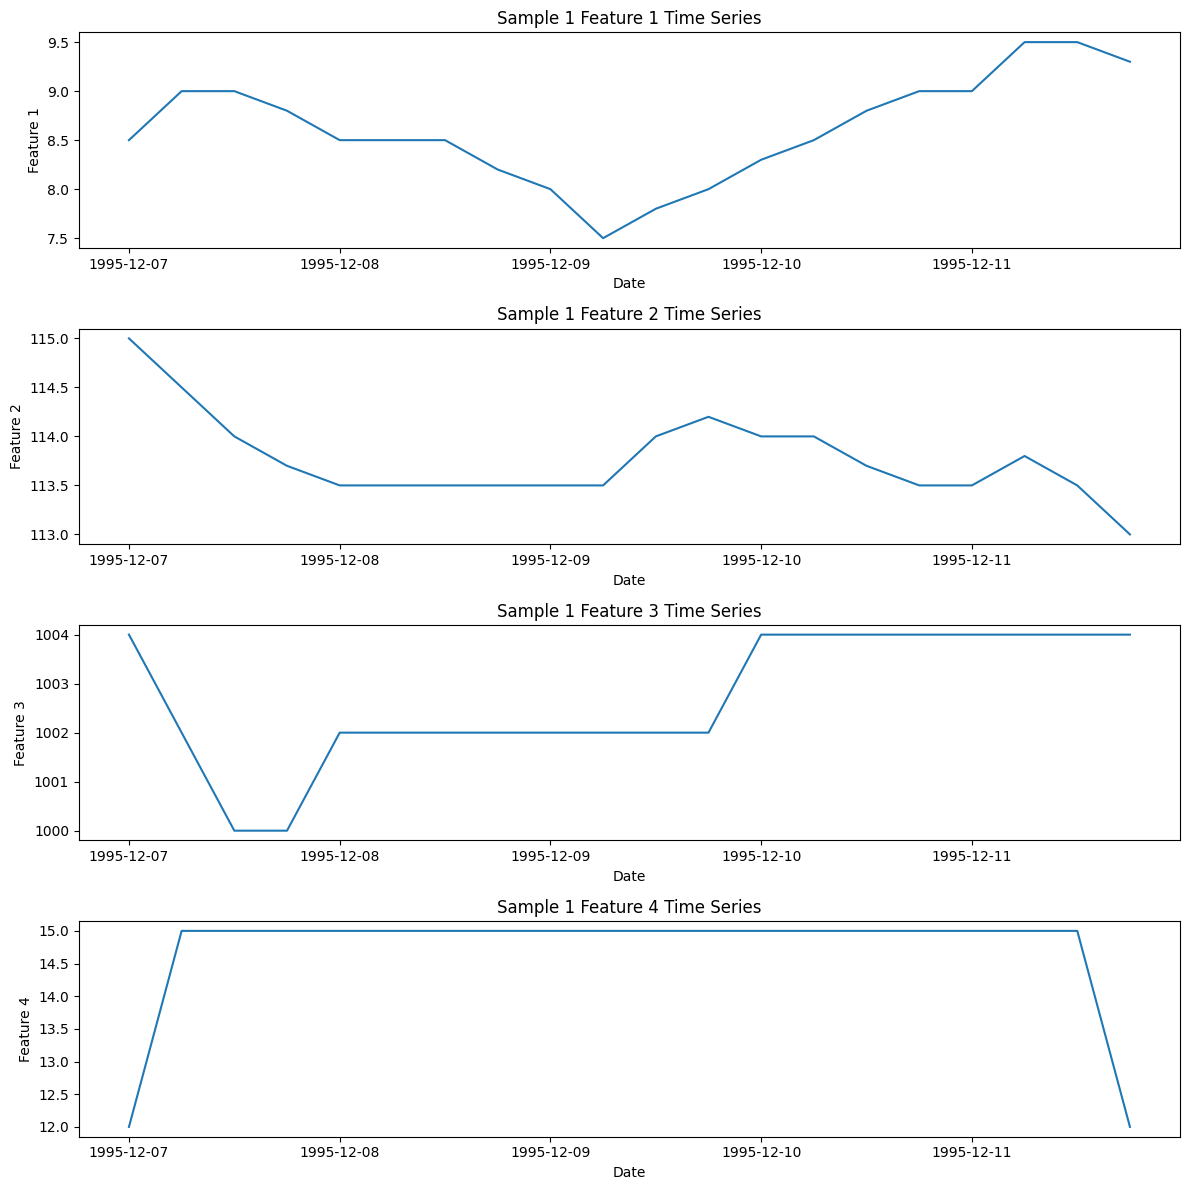

In [52]:
import matplotlib.pyplot as plt

# 假设 df_padded 是填充后的数据 numpy.ndarray，形状为 (样本数量, 时间戳数量, 特征数量)
# 假设日期数据在第2列，经度在第4列，纬度在第5列，最低气压在第6列，风速在第7列
dates = df_padded[:, :, 2]  # 日期数据
used_features = df_padded[:, :, 4:]  # 后四个特征数据

# 遍历前5个样本，为每个样本绘制后四个特征的时序图
for j in range(1):  # 只遍历前1个样本
    fig, axes = plt.subplots(4, 1, figsize=(12, 12))
    for i in range(used_features.shape[2]):  # 遍历后四个特征
        ax = axes[i] if used_features.shape[2] > 1 else axes  # 处理只有一个特征的情况
        ax.set_title(f"Sample {j+1} Feature {i+1} Time Series")
        ax.set_xlabel("Date")
        ax.set_ylabel(f"Feature {i+1}")
        # 绘制当前样本的当前特征时序图
        ax.plot(dates[j], used_features[j, :, i])
    plt.tight_layout()
    plt.show()


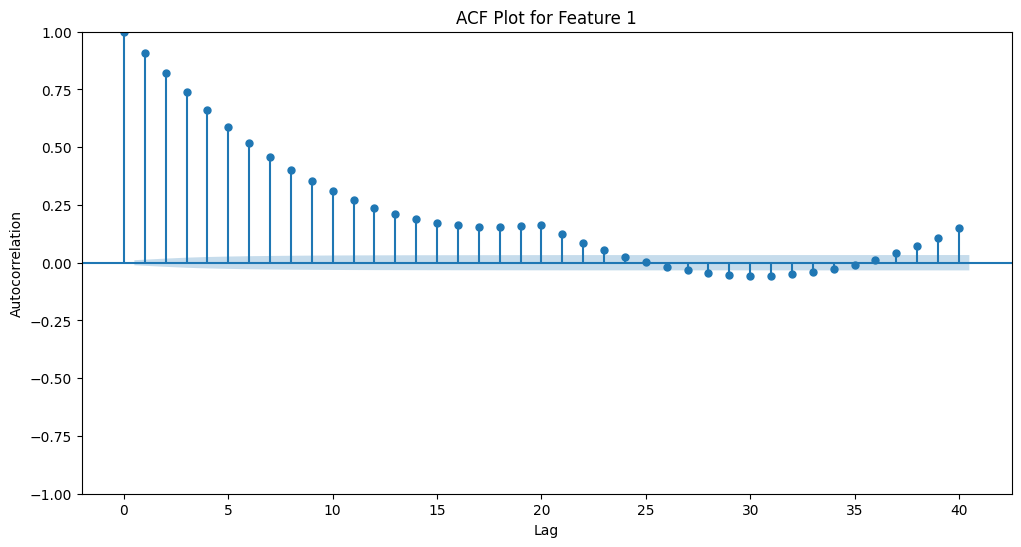

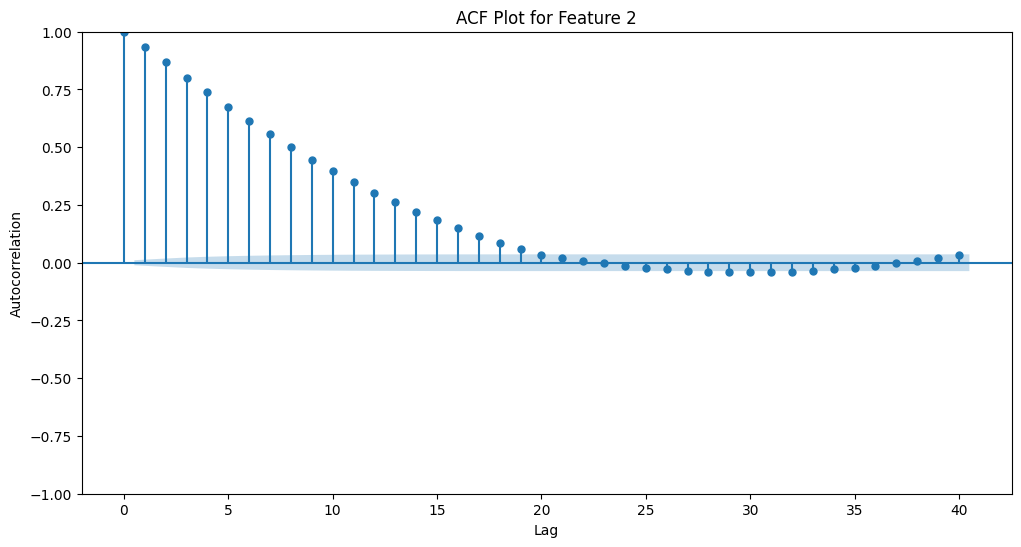

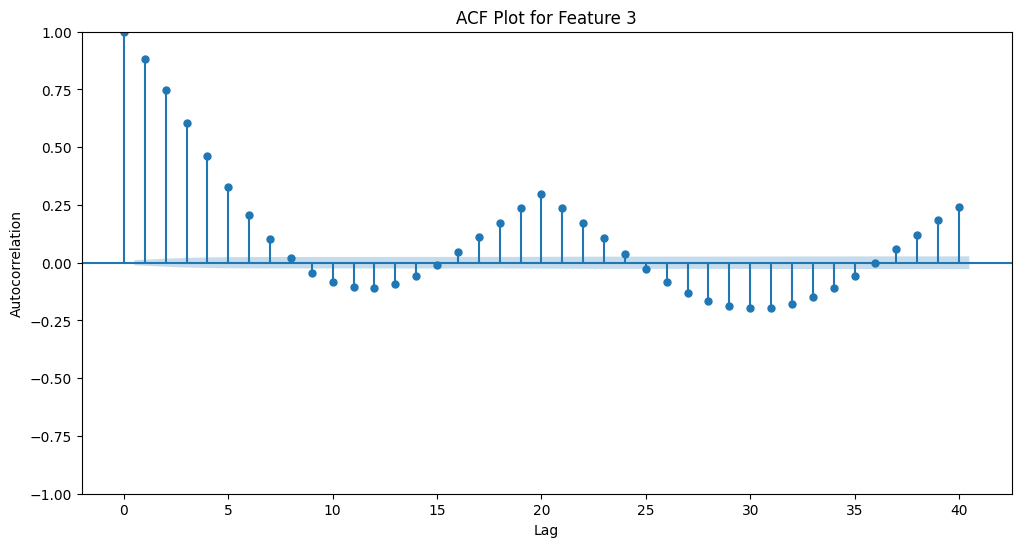

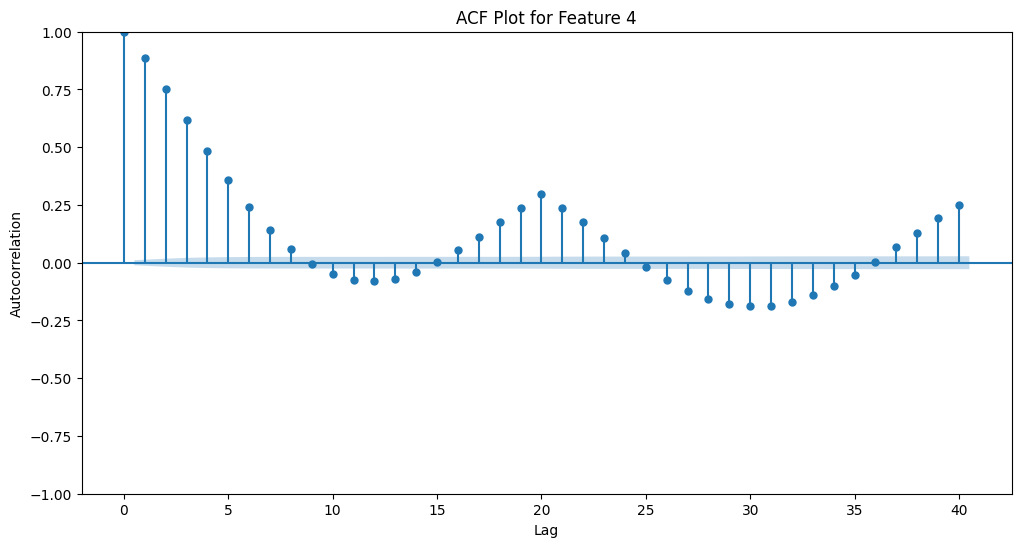

In [53]:
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt

# 遍历后四个特征，为每个特征绘制 ACF 图
for i in range(used_features.shape[2]):
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_acf(used_features[:, :, i].flatten(), ax=ax, lags=40)
    ax.set_title(f"ACF Plot for Feature {i+1}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Autocorrelation")
    plt.show()


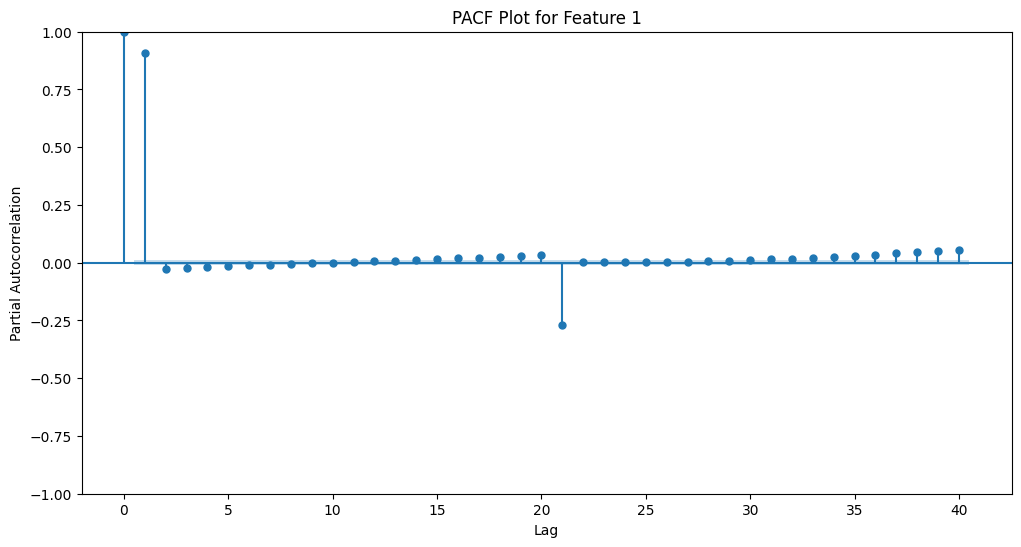

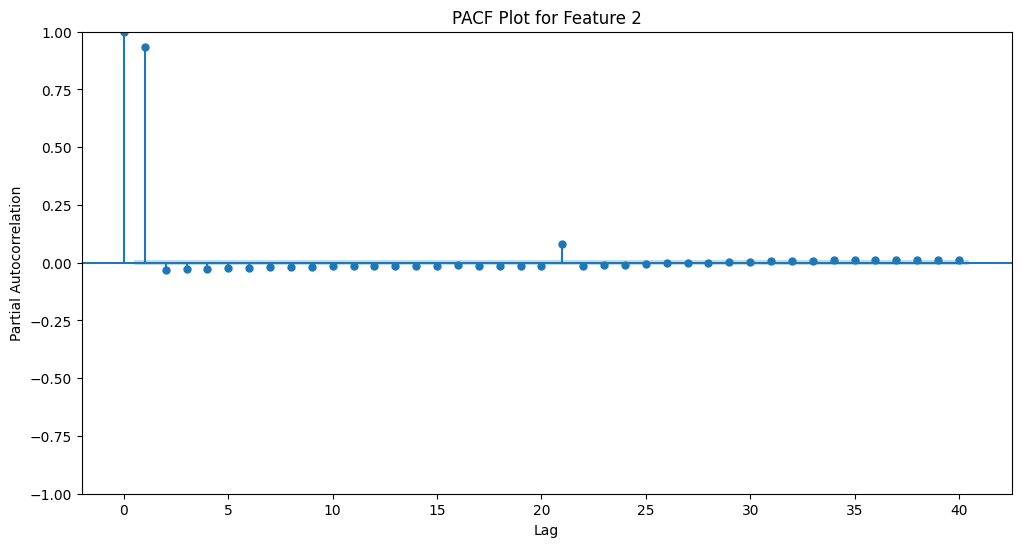

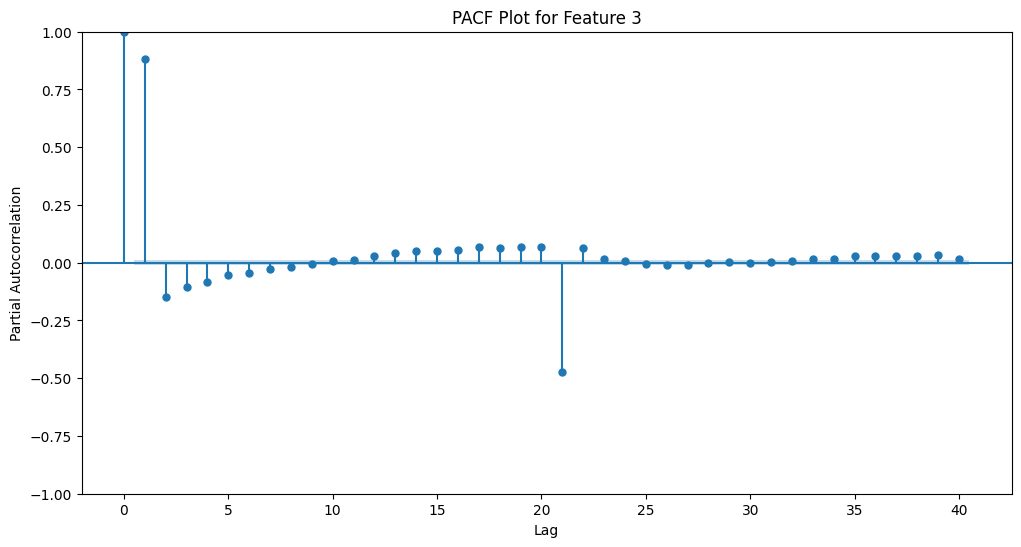

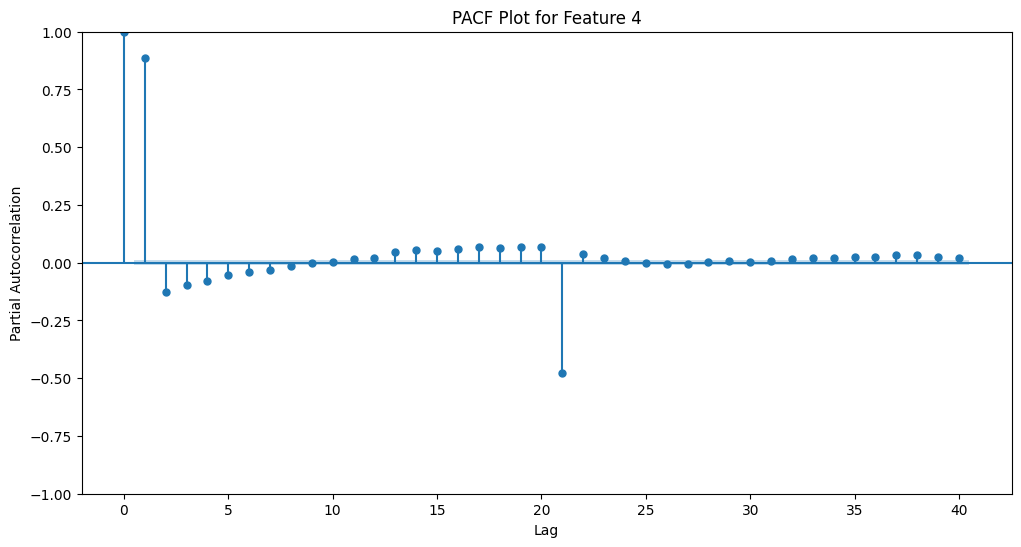

In [43]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt

# 遍历后四个特征，为每个特征绘制 PACF 图
for i in range(used_features.shape[2]):
    fig, ax = plt.subplots(figsize=(12, 6))
    plot_pacf(used_features[:, :, i].flatten(), ax=ax, lags=40)
    ax.set_title(f"PACF Plot for Feature {i+1}")
    ax.set_xlabel("Lag")
    ax.set_ylabel("Partial Autocorrelation")
    plt.show()


In [59]:
#AR看PACF图
p1=1
p2=1
p3=1
p4=1
#认为本来就是平稳的
d=0
#MA看ACF图
q1=23
q2=18
q3=7
q4=8

                               SARIMAX Results                                
Dep. Variable:               latitude   No. Observations:                65796
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -173653.220
Date:                Mon, 22 Apr 2024   AIC                         347314.441
Time:                        17:33:01   BIC                         347350.818
Sample:                             0   HQIC                        347325.692
                              - 65796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.7349      0.371     55.854      0.000      20.007      21.463
ar.L1          0.9177      0.002    383.219      0.000       0.913       0.922
ma.L1          0.0282      0.011      2.528      0.0

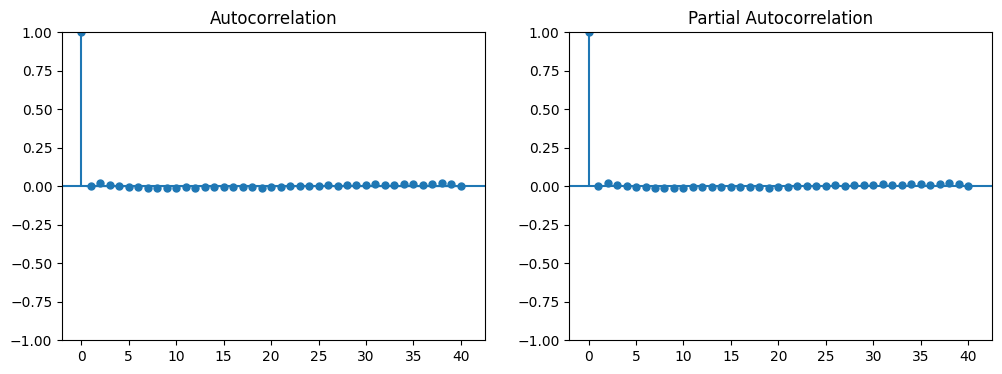

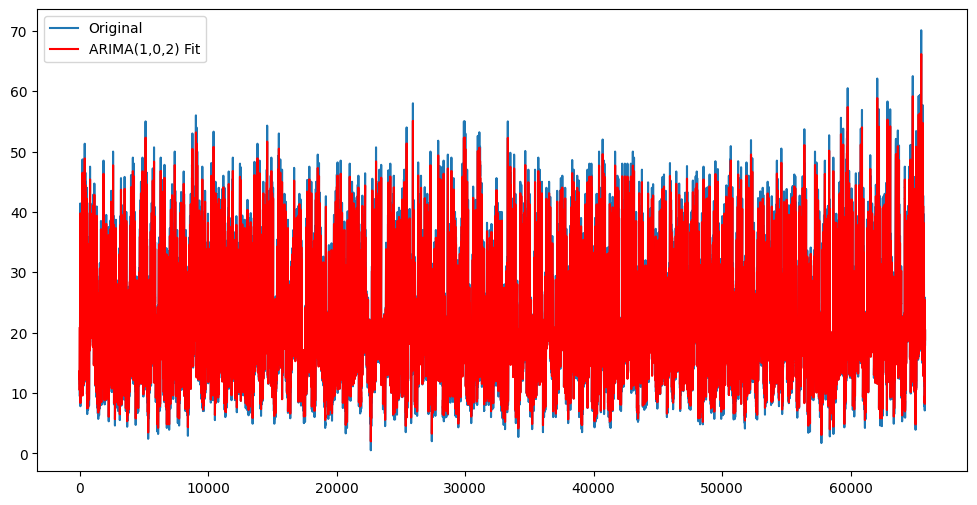

In [62]:
import polars as pl
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 将 Polars 的 Series 转换为 Pandas 的 DataFrame
df_filtered_pd = df_filtered.to_pandas()

# 拟合 ARIMA 模型
model = ARIMA(df_filtered_pd['latitude'], order=(1, 0, 1))
model_fit = model.fit()

# 打印模型的摘要信息
print(model_fit.summary())

# 绘制模型残差的 ACF 和 PACF 图
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=40)
plot_pacf(residuals, ax=ax[1], lags=40)
plt.show()

# 绘制原始数据和模型预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(df_filtered_pd['latitude'], label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='ARIMA(1,0,1) Fit')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:              longitude   No. Observations:                65796
Model:                 ARIMA(1, 0, 1)   Log Likelihood             -206217.178
Date:                Mon, 22 Apr 2024   AIC                         412442.357
Time:                        17:40:26   BIC                         412478.734
Sample:                             0   HQIC                        412453.608
                              - 65796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        133.4596      0.416    321.183      0.000     132.645     134.274
ar.L1          0.9369      0.002    412.202      0.000       0.932       0.941
ma.L1          0.0261      0.014      1.873      0.0

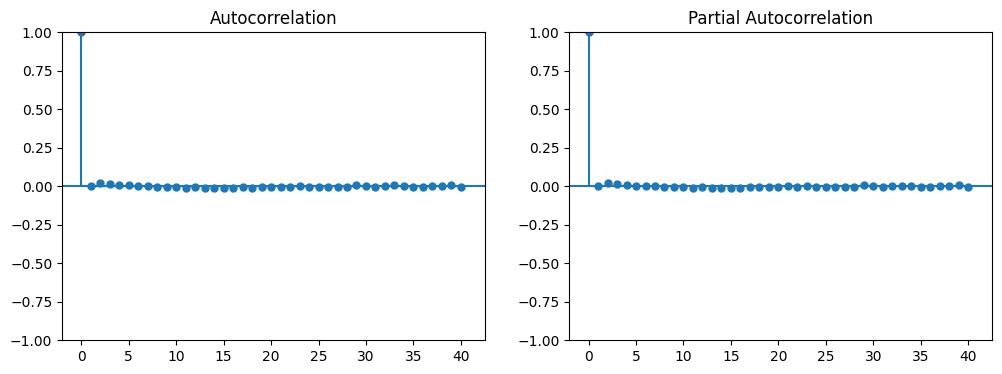

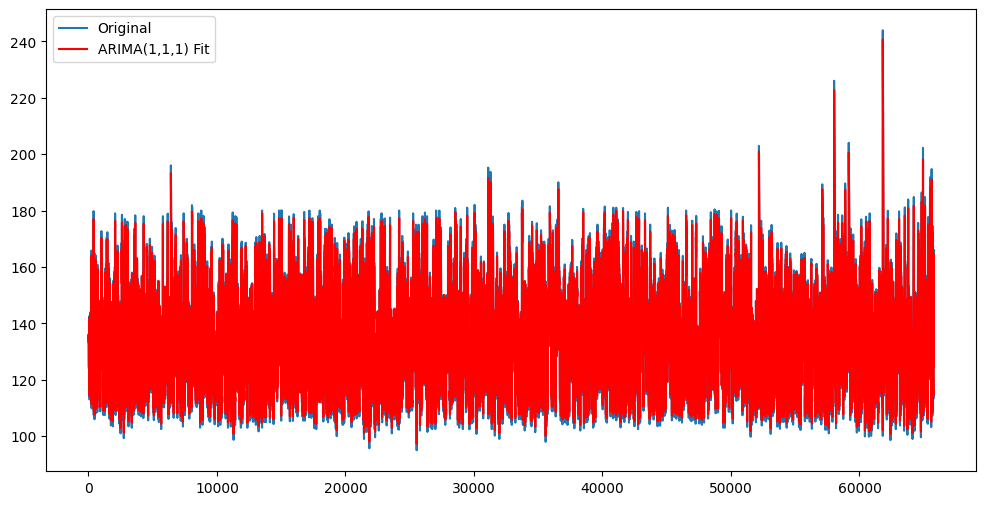

In [69]:
import polars as pl
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 将 Polars 的 Series 转换为 Pandas 的 DataFrame
df_filtered_pd = df_filtered.to_pandas()

# 拟合 ARIMA 模型
model = ARIMA(df_filtered_pd['longitude'], order=(1, 0, 1))
model_fit = model.fit()

# 打印模型的摘要信息
print(model_fit.summary())

# 绘制模型残差的 ACF 和 PACF 图
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=40)
plot_pacf(residuals, ax=ax[1], lags=40)
plt.show()

# 绘制原始数据和模型预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(df_filtered_pd['longitude'], label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='ARIMA(1,0,1) Fit')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:        lowest_pressure   No. Observations:                65796
Model:                 ARIMA(1, 0, 7)   Log Likelihood             -185616.145
Date:                Mon, 22 Apr 2024   AIC                         371252.290
Time:                        17:41:31   BIC                         371343.233
Sample:                             0   HQIC                        371280.419
                              - 65796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        984.8950      0.459   2144.364      0.000     983.995     985.795
ar.L1          0.8986      0.002    391.759      0.000       0.894       0.903
ma.L1          0.4436      0.003    155.429      0.0

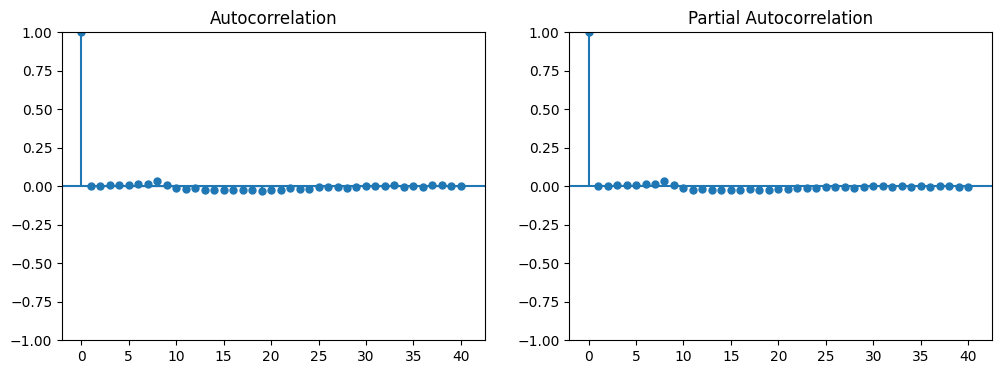

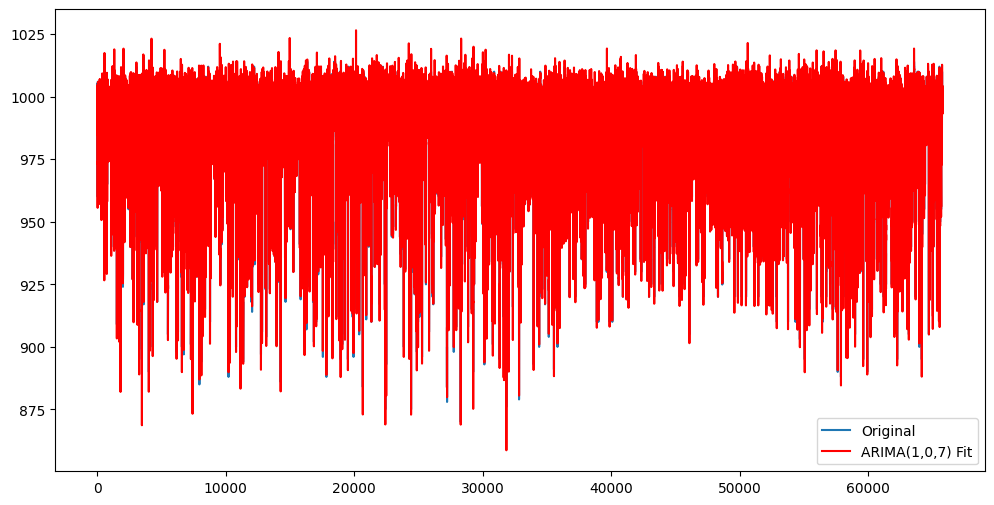

In [70]:
import polars as pl
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 将 Polars 的 Series 转换为 Pandas 的 DataFrame
df_filtered_pd = df_filtered.to_pandas()

# 拟合 ARIMA 模型
model = ARIMA(df_filtered_pd['lowest_pressure'], order=(1, 0, 7))
model_fit = model.fit()

# 打印模型的摘要信息
print(model_fit.summary())

# 绘制模型残差的 ACF 和 PACF 图
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=40)
plot_pacf(residuals, ax=ax[1], lags=40)
plt.show()

# 绘制原始数据和模型预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(df_filtered_pd['lowest_pressure'], label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='ARIMA(1,0,7) Fit')
plt.legend()
plt.show()


                               SARIMAX Results                                
Dep. Variable:             wind_speed   No. Observations:                65796
Model:                 ARIMA(1, 0, 8)   Log Likelihood             -166454.998
Date:                Mon, 22 Apr 2024   AIC                         332931.995
Time:                        17:43:03   BIC                         333032.033
Sample:                             0   HQIC                        332962.937
                              - 65796                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.8918      0.274     94.629      0.000      25.356      26.428
ar.L1          0.8851      0.003    304.782      0.000       0.879       0.891
ma.L1          0.3667      0.004     96.878      0.0

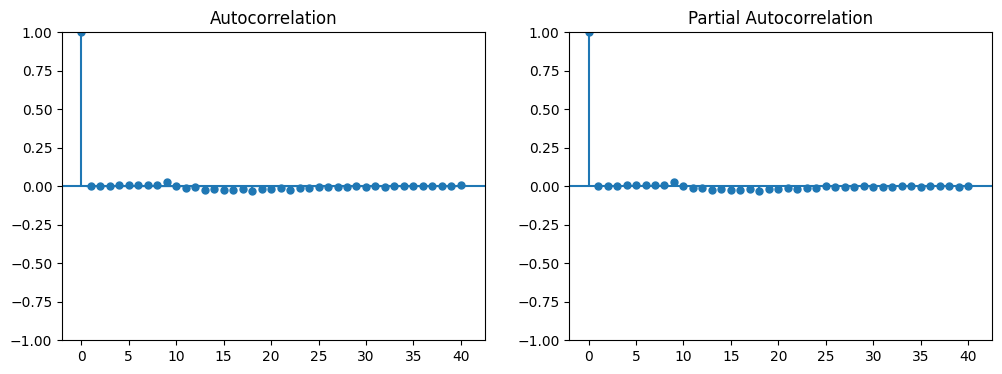

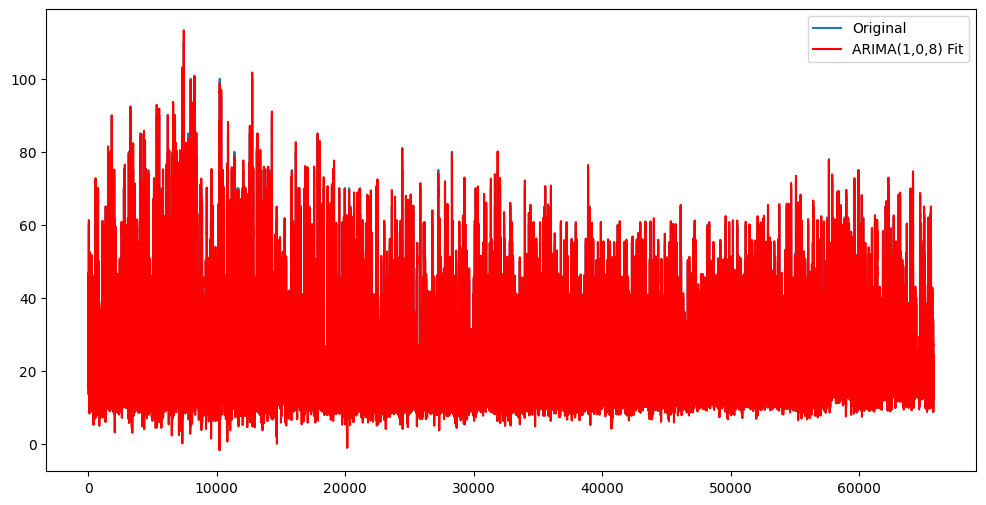

In [71]:
import polars as pl
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

# 将 Polars 的 Series 转换为 Pandas 的 DataFrame
df_filtered_pd = df_filtered.to_pandas()

# 拟合 ARIMA 模型
model = ARIMA(df_filtered_pd['wind_speed'], order=(1, 0, 8))
model_fit = model.fit()

# 打印模型的摘要信息
print(model_fit.summary())

# 绘制模型残差的 ACF 和 PACF 图
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(residuals, ax=ax[0], lags=40)
plot_pacf(residuals, ax=ax[1], lags=40)
plt.show()

# 绘制原始数据和模型预测值的对比图
plt.figure(figsize=(12, 6))
plt.plot(df_filtered_pd['wind_speed'], label='Original')
plt.plot(model_fit.fittedvalues, color='red', label='ARIMA(1,0,8) Fit')
plt.legend()
plt.show()
